# Disaster Tweets: Simple Linear Model

Greetings! Thanks for checking out my code. 

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
stopwords = stopwords.words('english')
import re
import string
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from tqdm import tqdm

SEED = 42

sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]
pd.set_option.display_max_columns = 0
pd.set_option.display_max_rows = 0

In [2]:
train = pd.read_csv("assets/train.csv")
test = pd.read_csv("assets/test.csv")

**Data Cleaning Functions**

Many thanks to https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#Data-Cleaning.

In [3]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html_tags(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

# See https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punctuation(text):
    punc = str.maketrans('', '', string.punctuation)
    return text.translate(punc)

In [8]:
for dataset in [train, test]:
    dataset["text"] = dataset["text"].apply(remove_url).apply(remove_html_tags).apply(remove_emoji).apply(remove_punctuation).apply(str.lower)

In [9]:
train["text"].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

**Building the Vectors - CountVectorizer**

In [12]:
count_vectorizer = CountVectorizer()

ex_embeddings = count_vectorizer.fit_transform(train["text"][0:5])

In [14]:
print(ex_embeddings[0].todense().shape)
print(ex_embeddings[0].todense())

(1, 53)
[[0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


In [15]:
train_vectors = count_vectorizer.fit_transform(train["text"])
test_vectors = count_vectorizer.transform(test["text"])

In [41]:
train_vectors.shape

(7613, 17798)

**Visualizing the Embeddings**

We use LDA to reduce dimensions by maximizing the separation of categories. LD1 (the first new axis that LDA creates) accounts for the most variation between categories.

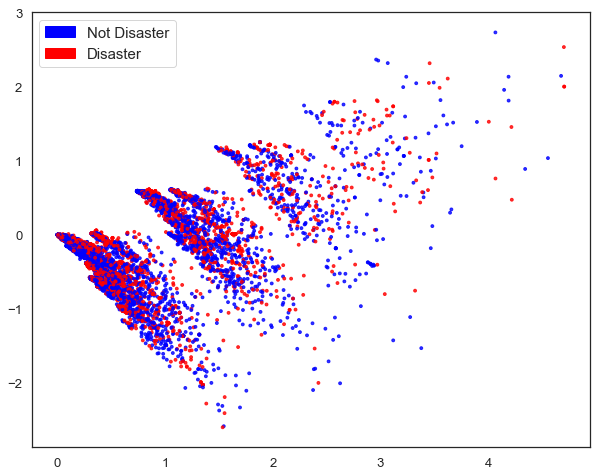

In [43]:
# Latent Semantical Analysis (LSA) - apply SVD to sparse input matrix, applied to text after it has been processed with TfidfVectorizer or CountVectorizer
def plot_LSA(X, y, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(X)
    lsa_scores = lsa.transform(X)
    color_mapper = {label:idx for idx,label in enumerate(set(y))}
    color_column = [color_mapper[label] for label in y]
    colors = ["blue", "red"]
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=0.8, c=y, cmap=matplotlib.colors.ListedColormap(colors))
        blue_patch = mpatches.Patch(color="blue", label="Not Disaster")
        red_patch = mpatches.Patch(color="red", label="Disaster")
        plt.legend(handles=[blue_patch, red_patch], prop={"size": 15})
        
plot_LSA(train_vectors, train["target"])
plt.show()

**Cross Val**

In [17]:
clf = linear_model.RidgeClassifier(random_state=SEED)
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=3, scoring="f1")
scores

array([0.62001037, 0.55512195, 0.61985472])

**TfidfVectorizer**

In [39]:
tfidf_vectorizer = TfidfVectorizer()

train_vectors_tfidf = tfidf_vectorizer.fit_transform(train["text"])
test_vectors_tfidf = tfidf_vectorizer.transform(test["text"])

In [40]:
train_vectors_tfidf.shape

(7613, 17798)

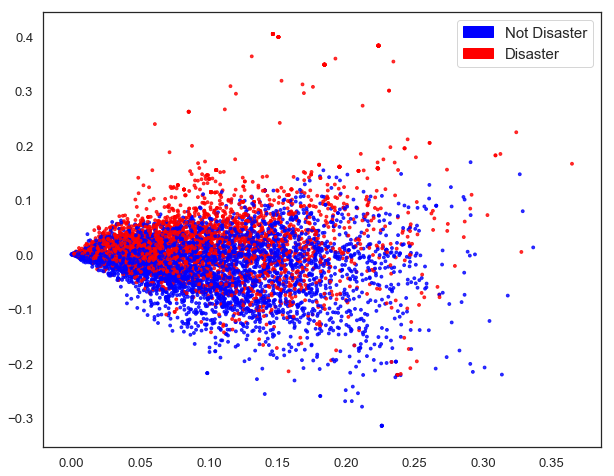

In [44]:
plot_LSA(train_vectors_tfidf, train["target"])

In [45]:
clf = linear_model.RidgeClassifier(random_state=SEED)
scores = model_selection.cross_val_score(clf, train_vectors_tfidf, train["target"], cv=3, scoring="f1")
scores

array([0.6376652 , 0.59652814, 0.66255144])

**GLoVe**

Incorporate context distance - higher values for words that often appear in the same context.

https://github.com/stanfordnlp/GloVe

In [69]:
def create_corpus(df):
    corpus = []
    for tweet in tqdm(df["text"]):
        words = [word for word in word_tokenize(tweet) if (word.isalpha()==1)]
        corpus.append(words)
    return corpus

In [70]:
corpus = create_corpus(train)

100%|██████████| 7613/7613 [00:00<00:00, 11301.60it/s]


In [72]:
embedding_dict={}
with open('assets/glove.6B.100d.txt','r', encoding="utf-8") as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

**Generate a Submission**

In [46]:
clf.fit(train_vectors_tfidf, train["target"])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=42, solver='auto',
        tol=0.001)

In [48]:
def generate_submission(model, test_vectors, save=False):
    preds = model.predict(test_vectors)
    output = pd.DataFrame()
    output["id"] = test["id"]
    output["target"] = preds
    if save:
        output.to_csv("submissions/linear-model-tfidf.csv", index=False)
    return output

In [49]:
output = generate_submission(clf, test_vectors_tfidf, True)
output.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


### Conclusion

Thanks very much for reading; I hope you enjoyed learning how to build a linear model using vectorized NLP data. If you did, be sure to upvote so you can find this notebook again easily in your Favorites tab.

Until next time, happy coding :)